# Notebook 1: Data Preprocessing
Kaggle link: https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability

Some definitions to avoid confusion:
- Development set is the dataset we are going to use for model training and evaluation.
- Submission set is the dataset that we are going to make prediction and submit to Kaggle.

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [2]:
from utils import *

In [3]:
import os, re, gc

In [4]:
path = os.getcwd()
wd = os.path.dirname(path).replace("\\", "/")
data_path = wd + "/data"

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Dataset Reading

In [6]:
table_list = [
    "base",
    # "credit_bureau_a_2",
    "applprev_1",
    "applprev_2",
    "credit_bureau_a_1",
    "credit_bureau_b_1",
    "credit_bureau_b_2",
    "debitcard_1",
    "other_1",
    "person_1",
    "person_2",
    "static_0",
    "static_cb_0",
    # "tax_registry_a_1",
    # "tax_registry_b_1",
    # "tax_registry_c_1"
]

Read all the required tables and store as a dictionary of polars DataFrame with the table name as the key.

In [7]:
feat_def = pd.read_csv(data_path + "/feature_definitions.csv")

In [8]:
development = read_all_table(table_list, "train", data_path, True)

Reading train_base.csv
Reading train_applprev_1_1.csv
Reading train_applprev_1_0.csv
Reading train_applprev_2.csv
Reading train_credit_bureau_a_1_3.csv
Reading train_credit_bureau_a_1_2.csv
Reading train_credit_bureau_a_1_0.csv
Reading train_credit_bureau_a_1_1.csv
Reading train_credit_bureau_b_1.csv
Reading train_credit_bureau_b_2.csv
Reading train_debitcard_1.csv
Reading train_other_1.csv
Reading train_person_1.csv
Reading train_person_2.csv
Reading train_static_0_1.csv
Reading train_static_0_0.csv
Reading train_static_cb_0.csv


In [9]:
submission = read_all_table(table_list, "test", data_path, True)

Reading test_base.csv
Reading test_applprev_1_2.csv
Reading test_applprev_1_0.csv
Reading test_applprev_1_1.csv
Reading test_applprev_2.csv
Reading test_credit_bureau_a_1_4.csv
Reading test_credit_bureau_a_1_3.csv
Reading test_credit_bureau_a_1_2.csv
Reading test_credit_bureau_a_1_0.csv
Reading test_credit_bureau_a_1_1.csv
Reading test_credit_bureau_b_1.csv
Reading test_credit_bureau_b_2.csv
Reading test_debitcard_1.csv
Reading test_other_1.csv
Reading test_person_1.csv
Reading test_person_2.csv
Reading test_static_0_2.csv
Reading test_static_0_1.csv
Reading test_static_0_0.csv
Reading test_static_cb_0.csv


In [10]:
development_clean, submission_clean = {}, {}

In [11]:
sns.set_theme()
palette = sns.color_palette("pastel")
seed = 101
np.random.seed(seed)

## `base`

In [12]:
table = "base"

In [13]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [14]:
table_dev.shape

(1526659, 5)

In [15]:
summarize(table_dev, feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,count,mean,min,25%,50%,75%,max,std
0,0,case_id,0.0,NaN,False,1526659.0,1286076.571739,0.0,766197.5,1357358.0,1739022.5,2703454.0,718946.592285
1,1,date_decision,0.0,NaN,False,1526659,2019-10-16 09:50:50.588507136,2019-01-01 00:00:00,2019-06-13 00:00:00,2019-10-11 00:00:00,2020-01-26 00:00:00,2020-10-05 00:00:00,NaN
2,2,MONTH,0.0,NaN,False,1526659.0,201936.287982,201901.0,201906.0,201910.0,202001.0,202010.0,44.735975
3,3,WEEK_NUM,0.0,NaN,False,1526659.0,40.769036,0.0,23.0,40.0,55.0,91.0,23.797981
4,4,target,0.0,NaN,False,1526659.0,0.031437,0.0,0.0,0.0,0.0,1.0,0.174496


In [16]:
chosen_id = np.random.choice(table_dev["case_id"].unique(), size=5)
table_dev.filter(pl.col("case_id").is_in(chosen_id)).to_pandas()

,case_id,date_decision,MONTH,WEEK_NUM,target
0,250048,2020-09-04,202009,87,0
1,1255084,2019-01-16,201901,2,0
2,1819596,2020-03-17,202003,63,0
3,1857144,2020-06-08,202006,74,0
4,2701828,2020-09-28,202009,90,0


### Case ID

/Users/vincenttse/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vincenttse/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


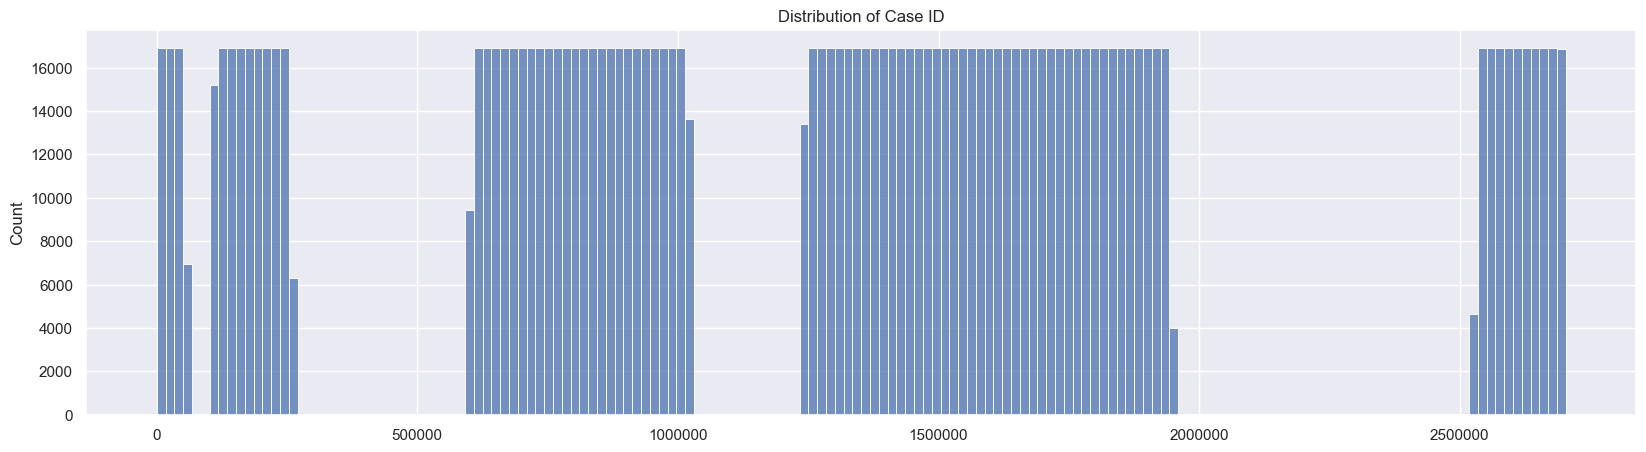

In [17]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.histplot(table_dev["case_id"])
ax.set_title("Distribution of Case ID")
ax.ticklabel_format(useOffset=False, style='plain');

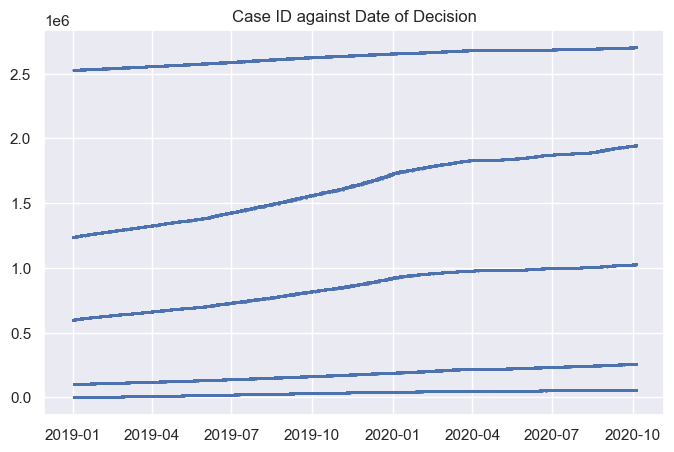

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(table_dev["date_decision"], table_dev["case_id"], s=.5)
ax.set_title("Case ID against Date of Decision");

From the 2 graph, `case_id` is obviously divided into 5 main groups and it does not depend on `date_decision`. While the host did not provide any information regarding the type of cases, we suspected this may represent either types of applicants or type of loan. Therefore, we try to identify the cutoff for the 5 group and store as features. 

In [19]:
table_dev.filter(pl.col("case_id") > 1e5)["case_id"].min()

103059

In [20]:
table_dev.filter(pl.col("case_id") > 5e5)["case_id"].min()

598836

In [21]:
table_dev.filter(pl.col("case_id") > 11e5)["case_id"].min()

1236927

In [22]:
table_dev.filter(pl.col("case_id") > 25e5)["case_id"].min()

2529833

In [23]:
case_gp = 1 * (table_dev["case_id"] < 103059).cast(pl.Int8) + 2 * (103059 <= table_dev["case_id"]).cast(pl.Int8) * (table_dev["case_id"] < 598836).cast(pl.Int8) +  3 * (598836 <= table_dev["case_id"]).cast(pl.Int8) * (table_dev["case_id"] < 1236927).cast(pl.Int8) + 4 * (1236927 <= table_dev["case_id"]).cast(pl.Int8) * (table_dev["case_id"] < 2529833).cast(pl.Int8) + 5 * (table_dev["case_id"] >= 2529833).cast(pl.Int8)
table_dev = table_dev.with_columns(case_gp.alias("case_gp").cast(pl.String).cast(pl.Categorical))

In [24]:
case_gp = 1 * (table_sub["case_id"] < 103059).cast(pl.Int8) + 2 * (103059 <= table_sub["case_id"]).cast(pl.Int8) * (table_sub["case_id"] < 598836).cast(pl.Int8) +  3 * (598836 <= table_sub["case_id"]).cast(pl.Int8) * (table_sub["case_id"] < 1236927).cast(pl.Int8) + 4 * (1236927 <= table_sub["case_id"]).cast(pl.Int8) * (table_sub["case_id"] < 2529833).cast(pl.Int8) + 5 * (table_sub["case_id"] >= 2529833).cast(pl.Int8)
table_sub = table_sub.with_columns(case_gp.alias("case_gp").cast(pl.String).cast(pl.Categorical))

In [25]:
table_dev["case_gp"].value_counts()

case_gp,count
cat,u32
"""1""",57625
"""2""",156678
"""3""",428595
"""4""",710180
"""5""",173581


In [26]:
table_sub["case_gp"].value_counts()

case_gp,count
cat,u32
"""1""",10


Group 1, 2 and 5 are under-represented in the data. We will perform upsampling before training models. we should also use one-hot encoding (but not ordinal encoding like the remaining features) as this may be a key factor to predict default. 

In [27]:
ohe = OneHotEncoder()

In [28]:
dev_case_gp = ohe.fit_transform(table_dev[["case_gp"]]).astype(int).toarray()
dev_case_gp = pl.from_numpy(dev_case_gp).cast(pl.Int8)
dev_case_gp.columns = [col.replace("column", "case_gp") for col in dev_case_gp.columns]
table_dev = pl.concat([table_dev, dev_case_gp], how="horizontal")

In [29]:
sub_case_gp = ohe.transform(table_sub[["case_gp"]]).astype(int).toarray()
sub_case_gp = pl.from_numpy(sub_case_gp).cast(pl.Int8)
sub_case_gp.columns = [col.replace("column", "case_gp") for col in sub_case_gp.columns]
table_sub = pl.concat([table_sub, sub_case_gp], how="horizontal")

### Target Distribution

/var/folders/r2/33czvw094ssg0r61q08cprnw0000gn/T/ipykernel_33770/306976956.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  defaults = table_dev[["target"]].group_by("target").count()


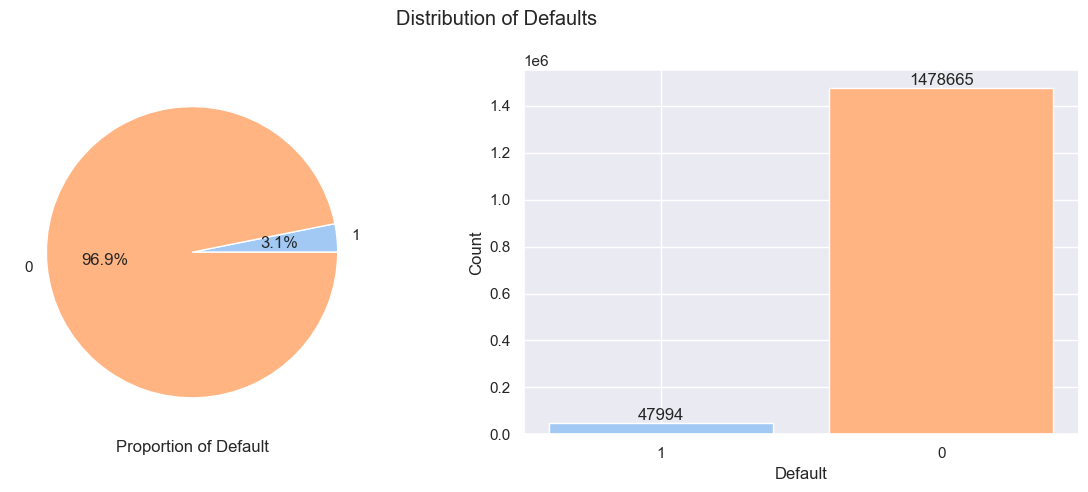

In [30]:
defaults = table_dev[["target"]].group_by("target").count()
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].pie(defaults["count"], labels=defaults["target"], autopct='%.1f%%', colors=palette)
axs[0].set_xlabel("Proportion of Default")
bars = axs[1].bar(defaults["target"].cast(pl.String), defaults["count"], label=defaults["target"], color=palette)
axs[1].bar_label(bars, fmt='%d')
axs[1].set_xlabel("Default")
axs[1].set_ylabel("Count")
fig.suptitle("Distribution of Defaults")
plt.tight_layout();

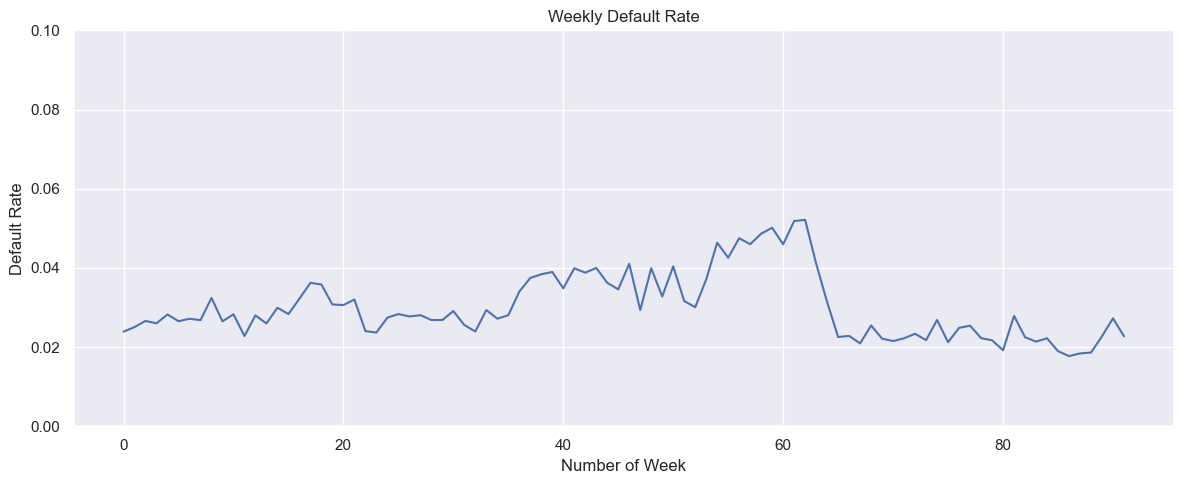

In [31]:
weekly_DR = table_dev[["WEEK_NUM", "target"]].group_by("WEEK_NUM").mean()
weekly_DR = weekly_DR.sort("WEEK_NUM")
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(weekly_DR["WEEK_NUM"], weekly_DR["target"])
ax.set_title("Weekly Default Rate")
ax.set_xlabel("Number of Week")
ax.set_ylabel("Default Rate")
ax.set_ylim(0,0.1)
plt.tight_layout();

Observations:
- The label is highly imbalanced
    - Use upsampling and/or focal loss function
- Observed Default Rate may vary with time
    - Possibly due to macro factor
    - Need to account for this issue to achieve model stability

In [32]:
development_clean[table] = table_dev.clone()
submission_clean[table] = table_sub.clone()

## Presence of `case_id` in each Table

In [33]:
dev_id_rec, sub_id_rec = id_presence(development), id_presence(submission)

In [34]:
pd.DataFrame({
    "train_count":dev_id_rec.sum(),
    "train_prop":dev_id_rec.sum()/dev_id_rec.sum().loc["base"],
    "test_count":sub_id_rec.sum(),
    "test_prop":sub_id_rec.sum()/sub_id_rec.sum().loc["base"]
})

,train_count,train_prop,test_count,test_prop
base,1526659,1.000000,10,1.0
applprev_1,1221522,0.800128,6,0.6
applprev_2,1221522,0.800128,4,0.4
credit_bureau_a_1,1386273,0.908044,2,0.2
credit_bureau_b_1,36500,0.023908,0,0.0
credit_bureau_b_2,36447,0.023874,0,0.0
debitcard_1,111772,0.073213,0,0.0
other_1,51109,0.033478,0,0.0
person_1,1526659,1.000000,3,0.3
person_2,1435105,0.940030,7,0.7


Conclusion:
- Tables with insufficient unique cases (in either training or testing set) should be drop.

## `static_0`

In [35]:
table = "static_0"

In [36]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [37]:
table_dev.shape

(1526659, 168)

In [38]:
table_sub.shape

(30, 150)

In [39]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,1526659.0,1.286077e+06,718946.5923,0.000,766197.5000,1.357358e+06,1.739022e+06,2.703454e+06
1,33,clientscnt_360L,0.0000,Number of clients that have the same alternative phone number and employer's phone number.,False,NaN,1526659.0,3.100000e-03,0.0613,0.000,0.0000,0.000000e+00,0.000000e+00,1.500000e+01
2,34,clientscnt_493L,0.0000,Number of clients with matching phone numbers for both the employer and the client.,False,NaN,1526659.0,1.580000e-02,1.2935,0.000,0.0000,0.000000e+00,0.000000e+00,9.220000e+02
3,35,clientscnt_533L,0.0000,Number of clients with same client's and alternative's phone number,False,NaN,1526659.0,7.550000e-02,0.2834,0.000,0.0000,0.000000e+00,0.000000e+00,1.200000e+01
4,36,clientscnt_887L,0.0000,Number of clients sharing the same employer's phone number.,False,NaN,1526659.0,2.313500e+00,38.2995,0.000,0.0000,0.000000e+00,0.000000e+00,1.242000e+03
5,37,clientscnt_946L,0.0000,Number of clients with matching mobile and employer's number.,False,NaN,1526659.0,3.240000e-02,0.3001,0.000,0.0000,0.000000e+00,0.000000e+00,7.200000e+01
6,41,credamount_770A,0.0000,Loan amount or credit card limit.,False,NaN,1526659.0,4.987017e+04,44147.4883,2000.000,19998.0000,3.519940e+04,6.398000e+04,9.500000e+05
7,49,deferredmnthsnum_166L,0.0000,Number of deferred months.,True,NaN,1526659.0,0.000000e+00,0.0000,0.000,0.0000,0.000000e+00,0.000000e+00,0.000000e+00
8,50,disbursedcredamount_1113A,0.0000,Disbursed credit amount after consolidation.,False,NaN,1526659.0,4.607477e+04,42500.0781,0.000,18400.0000,3.194600e+04,6.000000e+04,9.500000e+05
9,52,downpmt_116A,0.0000,Amount of downpayment.,False,NaN,1526659.0,5.523810e+02,4078.0427,0.000,0.0000,0.000000e+00,0.000000e+00,4.618674e+05


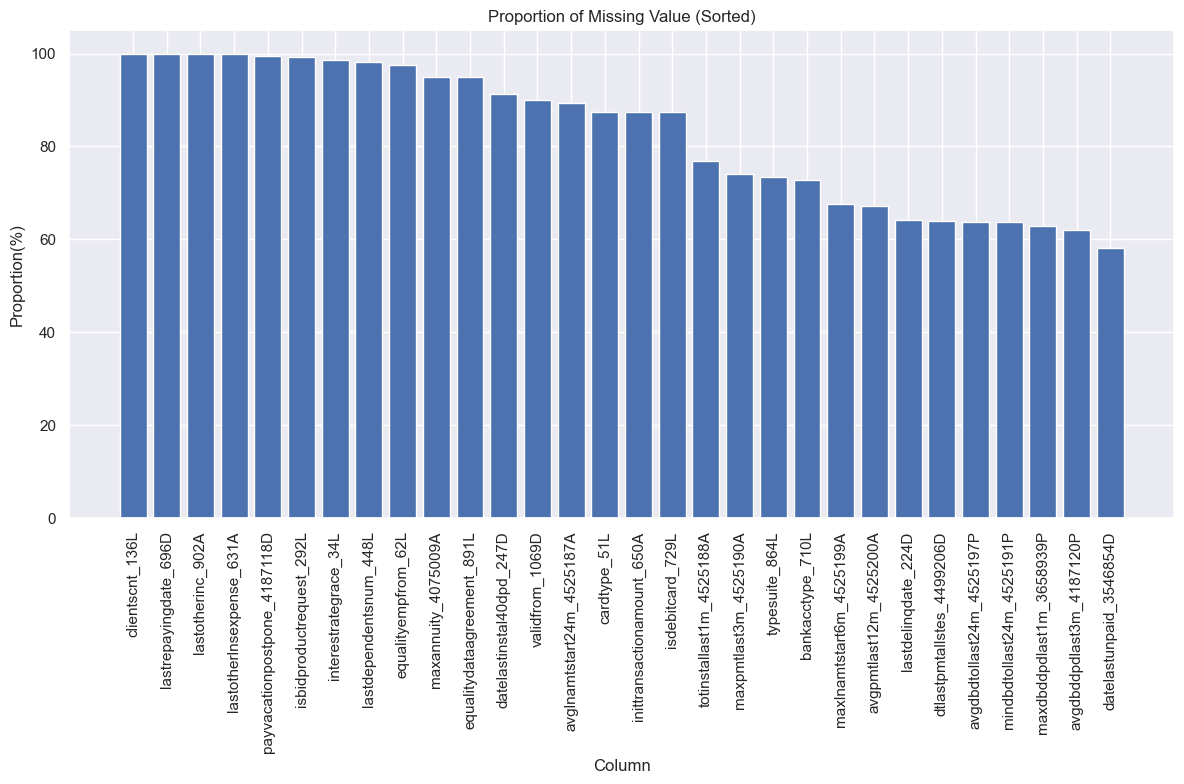

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
null_plot(ax, table_dev)
plt.tight_layout();

In [41]:
view_sample_obvs(table_dev, seed)

,case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,equalityempfrom_62L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,interestrategrace_34L,isbidproduct_1095L,isbidproductrequest_292L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcommoditytypec_5251766M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastdependentsnum_448L,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastrepayingdate_696D,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
0,250048,0.0,111929.601562,3955.400146,0.000000,0.0,6.0,30.0,0.0,0.0,17.0,-4.0,-14.0,-7.0,1.0,7689.600098,40600.0,3.0,62007.886719,8667.799805,CA,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,14.0,22.0,0.0,100000.0,CAL,40405.0937

Missing Value Handling:
- Drop column with missing proportion > 0.99.
- Use representation instead of imputation.
- For categorical features, use null as a category.
- For numerical features, use an impossible (e.g. out of range value like -1) to represent missingness.

In [42]:
drop_list = summary.loc[summary["Missing_Prop"] > .99, "Column"].to_numpy()
table_dev = table_dev.drop(drop_list)
table_sub = table_sub.drop(drop_list)

In [43]:
table_dev = fill_missing_value(table_dev)
table_sub = fill_missing_value(table_sub)

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [44]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0,NaN,False,NaN,1526659.0,1.286077e+06,718946.5923,0.0,766197.5,1.357358e+06,1.739022e+06,2.703454e+06
1,103,numinstlswithdpd5_4187116L,0.0,Number of instalments that were overdue by at least 5 days.,False,NaN,1526659.0,1.051600e+00,4.1368,-1.0,-1.0,0.000000e+00,0.000000e+00,8.900000e+01
2,104,numinstlswithoutdpd_562L,0.0,Number of instalments that were not past due date.,False,NaN,1526659.0,2.194070e+01,31.2745,-1.0,-1.0,1.100000e+01,3.100000e+01,8.610000e+02
3,105,numinstmatpaidtearly2d_4499204L,0.0,Number of instalments that have been paid more than 2 days before their due date.,False,NaN,1526659.0,9.557400e+00,21.6242,-1.0,-1.0,-1.000000e+00,1.100000e+01,3.470000e+02
4,106,numinstpaid_4499208L,0.0,Number of paid instalments.,False,NaN,1526659.0,1.434310e+01,28.5089,-1.0,-1.0,-1.000000e+00,1.900000e+01,3.930000e+02
5,107,numinstpaidearly3d_3546850L,0.0,Number of instalments paid more than three days before the due date.,False,NaN,1526659.0,1.377570e+01,22.8923,-1.0,-1.0,5.000000e+00,1.800000e+01,3.730000e+02
6,108,numinstpaidearly3dest_4493216L,0.0,Number of instalments that have been paid more than 3 days in advance of the due date.,False,NaN,1526659.0,8.646700e+00,20.0268,-1.0,-1.0,-1.000000e+00,1.000000e+01,3.220000e+02
7,109,numinstpaidearly5d_1087L,0.0,Number of instalments paid more than 5 days prior to the due date.,False,NaN,1526659.0,2.920000e+00,7.8045,-1.0,-1.0,0.000000e+00,4.000000e+00,2.780000e+02
8,102,numinstlswithdpd10_728L,0.0,Number of instalments that were overdue for 10 or more days.,False,NaN,1526659.0,2.233600e+00,9.6422,-1.0,-1.0,0.000000e+00,0.000000e+00,3.300000e+02
9,110,numinstpaidearly5dest_4493211L,0.0,Number of instalments that were paid more than 5 days before the due date.,False,NaN,1526659.0,9.100000e-01,3.6718,-1.0,-1.0,-1.000000e+00,1.000000e+00,5.900000e+01


In [45]:
drop_list = summary.loc[summary["All_Obvs_Equal"], "Column"].to_numpy()
table_dev = table_dev.drop(drop_list)
table_sub = table_sub.drop(drop_list)

In [46]:
table_dev.shape

(1526659, 161)

In [47]:
table_sub.shape

(30, 148)

In [48]:
# Handle missing columns in df_test
df = pl.concat([table_dev, table_sub], how="diagonal_relaxed")
df = fill_missing_value(df)
table_sub = df.tail(table_sub.shape[0])

/var/folders/r2/33czvw094ssg0r61q08cprnw0000gn/T/ipykernel_33770/3063161665.py:2: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = pl.concat([table_dev, table_sub], how="diagonal_relaxed")


In [49]:
table_sub.shape

(30, 161)

In [50]:
development_clean[table] = table_dev.clone()
submission_clean[table] = table_sub.clone()

## `static_cb_0`

In [51]:
table = "static_cb_0"

In [52]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [53]:
table_dev.shape

(1500476, 53)

In [54]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,1500476.0,1.284032e+06,716088.1235,357.0000,768508.7500,1.361878e+06,1.737010e+06,2.703454e+06
1,35,maritalst_893M,0.0000,Marital status of the client,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34,maritalst_385M,0.0000,Marital status of the client.,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15,education_88M,0.0000,Education level of the client.,False,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14,education_1103M,0.0000,Level of education of the client provided by external source.,False,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13,description_5085714M,0.0000,Categorization of clients by credit bureau.,False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,36,numberofqueries_373L,0.0765,Number of queries to credit bureau.,False,NaN,1385691.0,4.777100e+00,5.1711,0.0000,1.0000,3.000000e+00,6.500000e+00,1.150000e+02
7,33,fourthquarter_440L,0.0765,Number of results in fourth quarter.,False,NaN,1385691.0,2.851200e+00,3.4248,0.0000,0.0000,2.000000e+00,4.000000e+00,6.600000e+01
8,51,secondquarter_766L,0.0765,Number of results in second quarter.,False,NaN,1385691.0,2.688500e+00,3.3145,0.0000,0.0000,2.000000e+00,4.000000e+00,1.090000e+02
9,16,firstquarter_103L,0.0765,Number of results obtained from credit bureau in the first quarter.,False,NaN,1385691.0,2.860600e+00,3.6014,0.0000,0.0000,2.000000e+00,4.000000e+00,7.600000e+01


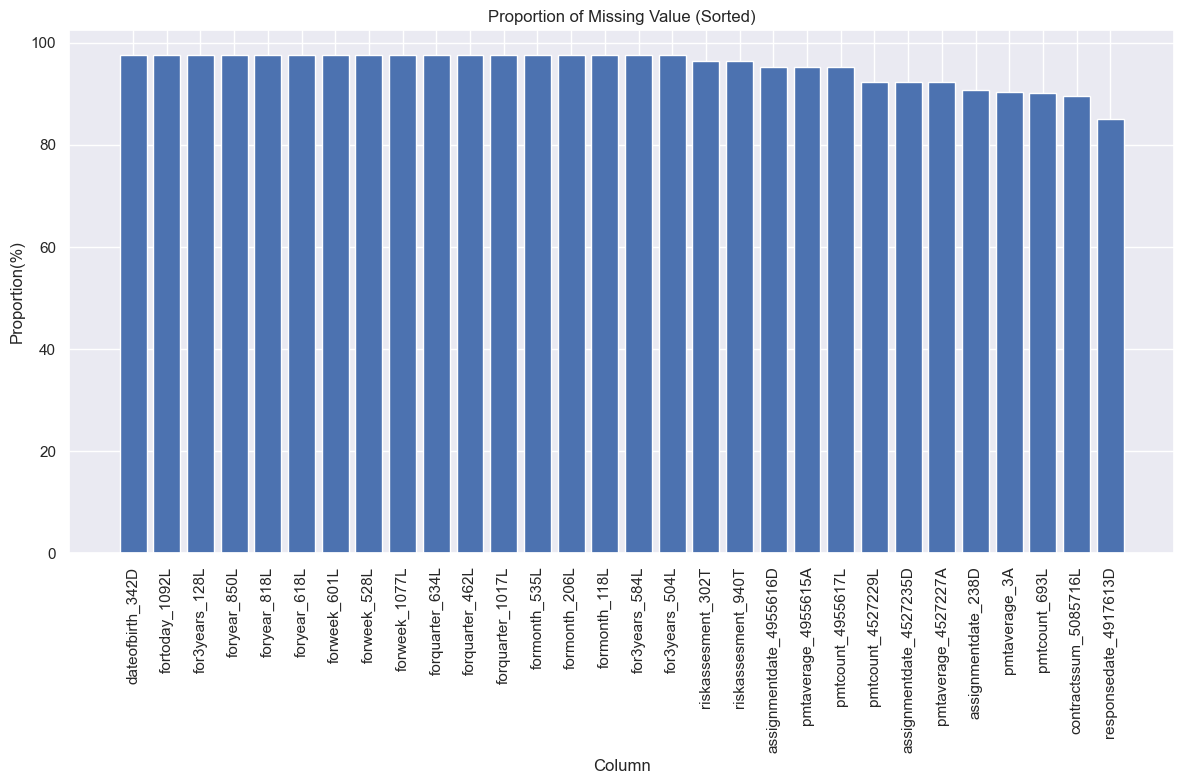

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
null_plot(ax, table_dev)
plt.tight_layout();

In [56]:
view_sample_obvs(table_dev, seed)

,case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,252113,NaN,NaN,NaN,NaN,2.004486e+06,17116,NaN,0.0,3.0,0.0,6.0,0.0,2fc785b2,a55475b1,a55475b1,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3439d993,a55475b1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,NaN,NaN,12.0,7.0
1,705112,NaN,NaN,NaN,13001.0,NaN,13001,NaN,2.0,2.0,1.0,4.0,2.0,a55475b1,6b2ae0fa,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3439d993,a55475b1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2560.000000,NaN,-14.0,NaN,NaN,NaN,NaN,2.0,3.0
2,1272576,NaN,NaN,NaN,15953.0,NaN,15953,NaN,1.0,1.0,1.0,2.0,1.0,a55475b1,6b2ae0fa,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,b6cabe76,a55475b1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,18840.794922,NaN,-14.0,NaN,NaN,NaN,NaN,0.0,2.0
3,1837221,NaN,NaN,NaN,NaN,NaN,15435,15435.0,5.0,6.0,0.0,6.0,4.0,a55475b1,a55475b1,a55475b1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3439d993,46b968c3,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,50% - 58%,-1.818808,0.0,0.0
4,1874771,NaN,NaN,NaN,NaN,1.344700e+05,16042,NaN,0.0,0.0,0.0,1.0,0.0,2fc785b2,717ddd49,a55475b1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3439d993,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.0,NaN,NaN,0.0,4.0


Missing Value Handling:
- Drop column with missing proportion > 0.99.
- Use representation instead of imputation.
- For categorical features, use null as a category.
- For numerical features, use an impossible (e.g. out of range value like -1) to represent missingness.

In [57]:
drop_list = summary.loc[summary["Missing_Prop"] > .99, "Column"].to_numpy()
table_dev = table_dev.drop(drop_list)
table_sub = table_sub.drop(drop_list)

In [58]:
table_dev = fill_missing_value(table_dev)
table_sub = fill_missing_value(table_sub)

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [59]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0,NaN,False,NaN,1500476.0,1.284032e+06,716088.1235,357.0000,768508.75,1361878.5,1737010.25,2.703454e+06
1,28,foryear_818L,0.0,Number of cancelations that occurred in last year.,False,NaN,1500476.0,-9.756000e-01,0.1537,-1.0000,-1.00,-1.0,-1.00,2.000000e+00
2,29,foryear_850L,0.0,Credit history for the last year.,False,NaN,1500476.0,-9.168000e-01,0.7607,-1.0000,-1.00,-1.0,-1.00,4.100000e+01
3,30,fourthquarter_440L,0.0,Number of results in fourth quarter.,False,NaN,1500476.0,2.556600e+00,3.4481,-1.0000,0.00,2.0,4.00,6.600000e+01
4,31,numberofqueries_373L,0.0,Number of queries to credit bureau.,False,NaN,1500476.0,4.335100e+00,5.1942,-1.0000,1.00,3.0,6.00,1.150000e+02
5,32,pmtaverage_3A,0.0,Average of tax deductions.,False,NaN,1500476.0,8.893687e+02,3260.7449,-1.0000,-1.00,-1.0,-1.00,1.452574e+05
6,33,pmtaverage_4527227A,0.0,Average of tax deductions.,False,NaN,1500476.0,7.679249e+02,3079.2195,-1.0000,-1.00,-1.0,-1.00,2.058486e+05
7,34,pmtaverage_4955615A,0.0,Average of tax deductions.,False,NaN,1500476.0,8.442389e+02,4058.7263,-1.0000,-1.00,-1.0,-1.00,9.908540e+04
8,35,pmtcount_4527229L,0.0,Number of tax deductions.,False,NaN,1500476.0,-4.178000e-01,2.1099,-1.0000,-1.00,-1.0,-1.00,1.500000e+01
9,36,pmtcount_4955617L,0.0,Number of tax deductions.,False,NaN,1500476.0,-3.267000e-01,3.0246,-1.0000,-1.00,-1.0,-1.00,1.600000e+01


In [60]:
table_dev.shape

(1500476, 53)

In [61]:
table_sub.shape

(10, 22)

In [62]:
# Handle missing columns in df_test
df = pl.concat([table_dev, table_sub], how="diagonal_relaxed")
df = fill_missing_value(df)
table_sub = df.tail(table_sub.shape[0])

/var/folders/r2/33czvw094ssg0r61q08cprnw0000gn/T/ipykernel_33770/3063161665.py:2: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = pl.concat([table_dev, table_sub], how="diagonal_relaxed")


In [63]:
table_sub.shape

(10, 53)

In [64]:
development_clean[table] = table_dev.clone()
submission_clean[table] = table_sub.clone()

## `applprev_1`

In [65]:
table = "applprev_1"

In [66]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [67]:
table_dev.shape

(6525979, 41)

In [68]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,6525979.0,1.431941e+06,7.871913e+05,2.000000e+00,958657.5,1.555975e+06,1.853312e+06,2.703454e+06
1,18,district_544M,0.0000,District of the address used in the previous loan application.,False,1063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22,education_1138M,0.0000,Applicant's education level from their previous application.,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37,rejectreasonclient_4145042M,0.0000,Reason for rejection of the client's previous application.,False,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,rejectreason_755M,0.0000,Reason for previous application rejection.,False,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,cancelreason_3545846M,0.0000,Application cancellation reason.,False,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,35,profession_152M,0.0000,Profession of the client during their previous loan application.,False,11508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,34,postype_4733339M,0.0000,Type of point of sale.,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,31,num_group1,0.0000,NaN,False,NaN,6525979.0,4.194400e+00,4.274800e+00,0.000000e+00,1.0,3.000000e+00,6.000000e+00,1.900000e+01
9,27,isbidproduct_390L,0.0000,Flag for determining if the product is a cross-sell in previous applications.,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# How many unique 'num_group1' per case
num_count = table_dev[["case_id", "num_group1"]].group_by('case_id').agg(pl.col('num_group1').n_unique()).sort("case_id")
num_count["num_group1"].to_pandas().describe()[1:]

mean     5.342498
std      4.649413
min      1.000000
25%      2.000000
50%      4.000000
75%      7.000000
max     20.000000
Name: num_group1, dtype: float64

In [70]:
view_sample_obvs(table_dev, seed)

,case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
0,963989,0.0,4753.200195,NaN,NaN,P85_114_140,NaN,-12,NaN,0.0,NaN,NaN,NaN,NaN,91994.000000,COL,NaN,NaN,a55475b1,0.0,NaN,NaN,a55475b1,NaN,NaN,-41.0,POS,False,None,30000.0,NaN,0,NaN,24.0,P67_102_161,a55475b1,a55475b1,a55475b1,NaN,T,24.0
1,1837133,0.0,2089.400146,109.0,NaN,a55475b1,NaN,109,0.0,0.0,0.0,0.0,AC,0.0,5998.000000,COL,0.0,91.0,P204_99_158,0.0,48.0,48.0,a55475b1,NaN,NaN,78.0,POS,False,None,77000.0,0.0,0,0.0,3.0,P177_117_192,a55475b1,a55475b1,a55475b1,NaN,K,3.0
2,1837133,0.0,8845.400391,163.0,NaN,a55475b1,NaN,163,NaN,0.0,NaN,NaN,NaN,NaN,26536.000000,COL,0.0,139.0,P204_99_158,0.0,76.0,76.0,a55475b1,NaN,NaN,133.0,POS,False,None,116000.0,0.0,1,0.0,3.0,P177_117_192,a55475b1,a55475b1,a55475b1,NaN,K,3.0
3,1837133,0.0,0.000000,221.0,NaN,a55475b1,NaN,221,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,REL,0.0,190.0,P204_99_158,0.0,NaN,NaN,a55475b1,NaN,NaN,NaN,NDF,False,True,97000.0,0.0,2,0.0,NaN,P46_145_78,a55475b1,a55475b1,a55475b1,780590208.0,A,NaN
4,1837133,0.0,5579.399902,221.0,NaN,a55475b1,NaN,221,NaN,0.0,NaN,NaN,NaN,NaN,16738.000000,COL,0.0,190.0,P204_99_158,0.0,134.0,134.0,a55475b1,NaN,NaN,191.0,POS,False,None,97000.0,0.0,3,0.0,3.0,P177_117_192,a55475b1,a55475b1,a55475b1,NaN,K,3.0
5,1837133,0.0,4227.800293,935.0,NaN,a55475b1,0.0,935,NaN,0.0,NaN,NaN,NaN,NaN,12680.000000,COL,0.0,932.0,P204_99_158,0.0,892.0,892.0,P33_146_175,NaN,MARRIED,903.0,POS,False,None,34000.0,0.0,4,0.0,3.0,P177_117_192,a55475b1,a55475b1,a55475b1,NaN,K,3.0
6,1837133,0.0,5075.200195,NaN,25000.0,a55475b1,0.0,2449,NaN,0.0,NaN,NaN,NaN,NaN,26800.000000,COL,NaN,NaN,P204_99_158,0.0,NaN,NaN,P97_36_170,3856.0,MARRIED,2418.0,POS,False,None,9600.0,NaN,5,NaN,6.0,P149_40_170,a55475b1,a55475b1,a55475b1,NaN,D,6.0
7,667959,0.0,3507.199951,NaN,NaN,P94_109_143,NaN,-13,NaN,0.0,NaN,NaN,NaN,NaN,17200.000000,COL,NaN,NaN,P98_137_111,0.0,NaN,NaN,a55475b1,NaN,NaN,-43.0,POS,False,None,30000.0,NaN,0,NaN,6.0,a55475b1,a55475b1,P45_84_106,P94_109_143,NaN,D,6.0
8,667959,0.0,2125.600098,38.0,NaN,a55475b1,NaN,38,NaN,0.0,NaN,NaN,NaN,NaN,5680.000000,COL,0.0,33.0,P98_137_111,0.0,-10.0,-10.0,P97_36_170,2275.0,MARRIED,10.0,POS,False,None,30000.0,0.0,1,0.0,3.0,a55475b1,a55475b1,a55475b1,a55475b1,NaN,K,3.0
9,667959,0.0,3277.199951,NaN,NaN,P94_109_143,NaN,481,NaN,0.0,NaN,NaN,NaN,NaN,16000.000000,COL,NaN,NaN,P98_137_111,20000.0,NaN,NaN,a55475b1,NaN,NaN,449.0,POS,False,None,20000.0,NaN,2,NaN,6.0,a55475b1,a55475b1,P99_56_166,P94_109_143,NaN,D,6.0


`num_group1` should be an application record for a credit account.

Missing Values:

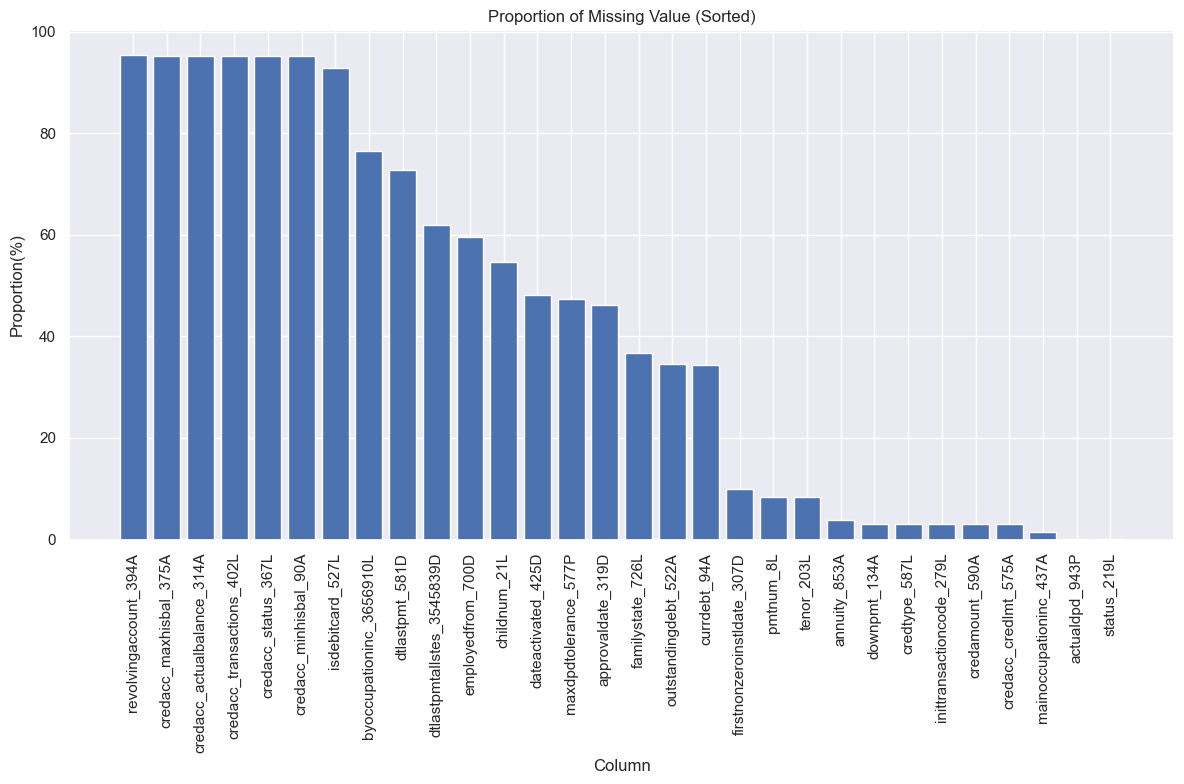

In [71]:
fig, ax = plt.subplots(figsize=(12,8))
null_plot(ax, table_dev)
plt.tight_layout();

In [72]:
summary[(0.2 < summary["Missing_Prop"]) & (summary["Missing_Prop"] < 0.9)]

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
23,16,currdebt_94A,0.3442,Previous application's current debt.,False,NaN,4279467.0,5257.1328,19327.0918,0.0,0.0,0.0,0.0,5.074297e+05
24,32,outstandingdebt_522A,0.3460,Amount of outstanding debt on the client's previous application.,False,NaN,4267711.0,7034.6572,29295.1738,0.0,0.0,0.0,0.0,1.210629e+06
25,24,familystate_726L,0.3668,Family State in previous application of applicant.,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,3,approvaldate_319D,0.4613,Approval Date of Previous Application,False,NaN,3515685.0,1242.3766,1172.5365,-14.0,355.0,815.0,1855.0,5.378000e+03
27,30,maxdpdtolerance_577P,0.4744,Maximum DPD with tolerance (on previous application/s).,False,NaN,3430275.0,14.6625,143.9703,0.0,0.0,0.0,1.0,4.362000e+03
28,17,dateactivated_425D,0.4814,Contract activation date of the applicant's previous application.,False,NaN,3384226.0,1254.9375,1177.2640,-14.0,359.0,824.0,1877.0,5.377000e+03
29,6,childnum_21L,0.5454,Number of children in the previous application.,False,NaN,2966555.0,0.8428,1.2196,0.0,0.0,0.0,1.0,2.000000e+01
30,23,employedfrom_700D,0.5955,Employment start date from the previous application.,False,NaN,2639501.0,4039.2269,2660.2916,-12.0,2242.0,3450.0,5117.0,2.109800e+04
31,21,dtlastpmtallstes_3545839D,0.6196,Date of the applicant's last payment.,False,NaN,2482358.0,385.6378,415.4895,-14.0,14.0,247.0,652.0,4.241000e+03
32,20,dtlastpmt_581D,0.7279,Date of last payment made by the applicant.,False,NaN,1775595.0,522.3676,406.7899,-14.0,177.0,438.0,805.0,4.241000e+03


- For p > 0.9: Drop all.
- For 0.2 < p < 0.9: Keep 94A, 577P, 522A and 577P only.
- For p < 0.2: Keep all.

In [73]:
drop_list = summary.loc[summary["Missing_Prop"] > 0.9, "Column"].to_numpy()
drop_list = np.concatenate([drop_list, ["familystate_726L", "approvaldate_319D", "dateactivated_425D", "childnum_21L", "employedfrom_700D", "dtlastpmtallstes_3545839D", "dtlastpmt_581D", "byoccupationinc_3656910L"]])

In [74]:
table_dev = table_dev.drop(drop_list)
table_sub = table_sub.drop(drop_list)

Scheme for aggregation:
- Date: max, min
- Numerical Column: mean, std
- Categorical Column: first, last

In [75]:
table_dev = aggregate(table_dev, count_obvs=True)
table_sub = aggregate(table_sub, count_obvs=True)

In [76]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,1221522.0,1.426493e+06,727480.5164,2.0,948908.2500,1.509926e+06,1.815307e+06,2.703454e+06
1,29,cancelreason_3545846M_first,0.0000,NaN,False,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31,district_544M_first,0.0000,NaN,False,969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32,education_1138M_first,0.0000,NaN,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34,postype_4733339M_first,0.0000,NaN,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,35,profession_152M_first,0.0000,NaN,False,1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,36,rejectreason_755M_first,0.0000,NaN,False,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,37,rejectreasonclient_4145042M_first,0.0000,NaN,False,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,38,status_219L_first,0.0000,NaN,False,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,39,cancelreason_3545846M_last,0.0000,NaN,False,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
drop_list = summary.loc[summary["All_Obvs_Equal"], "Column"].to_numpy()
table_dev = table_dev.drop(drop_list)
table_sub = table_sub.drop(drop_list)

In [78]:
table_dev = fill_missing_value(table_dev)
table_sub = fill_missing_value(table_sub)

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [79]:
table_dev.shape

(1221522, 50)

In [80]:
table_sub.shape

(14, 50)

In [81]:
summarize(table_dev, feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0,NaN,False,NaN,1221522.0,1.426493e+06,727480.5164,2.0,948908.2500,1.509926e+06,1.815307e+06,2.703454e+06
1,27,creationdate_885D_min,0.0,NaN,False,NaN,1221522.0,4.689857e+02,748.0970,-14.0,78.0000,2.170000e+02,4.950000e+02,5.354000e+03
2,28,firstnonzeroinstldate_307D_min,0.0,NaN,False,NaN,1221522.0,4.842416e+02,795.1617,-47.0,53.0000,2.070000e+02,5.190000e+02,5.323000e+03
3,29,obvs_count,0.0,NaN,False,NaN,1221522.0,5.342500e+00,4.6494,1.0,2.0000,4.000000e+00,7.000000e+00,2.000000e+01
4,30,cancelreason_3545846M_first,0.0,NaN,False,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,31,credtype_587L_first,0.0,NaN,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,32,district_544M_first,0.0,NaN,False,969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,33,education_1138M_first,0.0,NaN,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,34,inittransactioncode_279L_first,0.0,NaN,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,35,postype_4733339M_first,0.0,NaN,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
development_clean[table] = table_dev.clone()
submission_clean[table] = table_sub.clone()

## `applprev_2`

In [83]:
table = "applprev_2"

In [84]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [85]:
table_dev.shape

(14075487, 6)

In [86]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,14075487.0,1.454198e+06,787508.3638,2.0,1237440.0,1575626.0,1861301.0,2703454.0
1,4,num_group1,0.0000,NaN,False,NaN,14075487.0,4.551500e+00,4.3904,0.0,1.0,3.0,7.0,19.0
2,5,num_group2,0.0000,NaN,False,NaN,14075487.0,7.403000e-01,0.8026,0.0,0.0,1.0,1.0,11.0
3,1,cacccardblochreas_147M,0.0078,Card blocking reason.,False,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,conts_type_509L,0.1701,Person contact type in previous application.,False,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3,credacc_cards_status_52L,0.9757,Card status of the previous credit account.,False,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
view_sample_obvs(table_dev, seed)

,case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2
0,667959,a55475b1,PRIMARY_MOBILE,NaN,1,1
1,667959,a55475b1,PHONE,NaN,1,0
2,667959,a55475b1,PRIMARY_MOBILE,NaN,2,0
3,667959,a55475b1,PRIMARY_MOBILE,NaN,0,0
4,963989,a55475b1,PRIMARY_MOBILE,NaN,0,0
5,1478747,a55475b1,PRIMARY_MOBILE,NaN,3,0
6,1478747,a55475b1,PRIMARY_MOBILE,NaN,0,0
7,1478747,a55475b1,PRIMARY_MOBILE,NaN,1,0
8,1478747,a55475b1,PHONE,NaN,3,1
9,1478747,a55475b1,PHONE,NaN,1,1


`num_group1` is the credit card and `num_group2` is an incident of card blocking

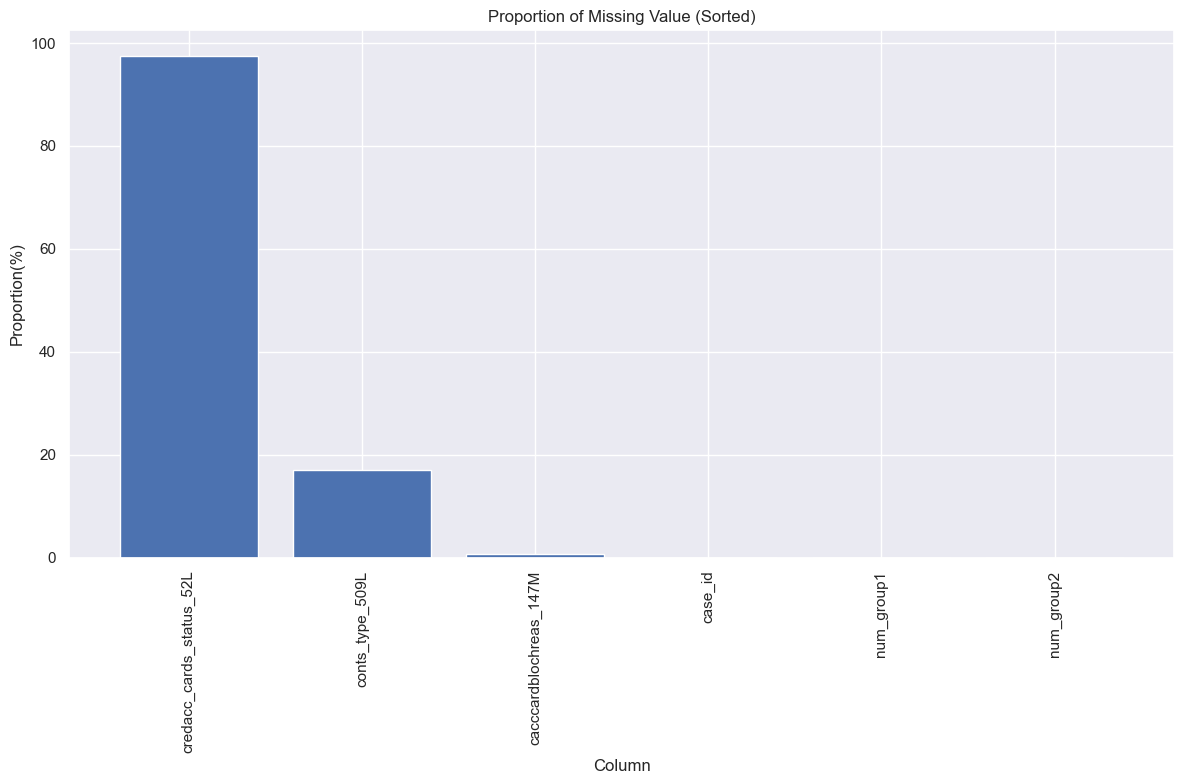

In [88]:
fig, ax = plt.subplots(figsize=(12,8))
null_plot(ax, table_dev)
plt.tight_layout();

In [89]:
# How many unique 'num_group1' per case
contract_count = table_dev[["case_id", "num_group1"]].group_by('case_id').agg(pl.col('num_group1').n_unique()).sort("case_id")["num_group1"]
contract_count.to_pandas().describe()[1:]

mean     5.342497
std      4.649413
min      1.000000
25%      2.000000
50%      4.000000
75%      7.000000
max     20.000000
Name: num_group1, dtype: float64

Conclusion:

- Use counter on num_group2 as the number of blocking per card. (+num_gp1 = number of blocking per head)
- card blocking reason: find mode per head

In [90]:
drop_list = ["credacc_cards_status_52L", "num_group1", "num_group2"]
table_dev = table_dev.drop(drop_list)
table_sub = table_sub.drop(drop_list)

In [91]:
table_dev = aggregate(table_dev)
table_sub = aggregate(table_sub)

In [92]:
summarize(table_dev, feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,1221522.0,1.426493e+06,727480.5164,2.0,948908.25,1509926.5,1815306.75,2703454.0
1,1,cacccardblochreas_147M_first,0.0200,NaN,False,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,cacccardblochreas_147M_last,0.0200,NaN,False,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,conts_type_509L_first,0.1373,NaN,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,conts_type_509L_last,0.1373,NaN,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
table_dev = fill_missing_value(table_dev)
table_sub = fill_missing_value(table_sub)

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [94]:
table_dev.shape

(1221522, 5)

In [95]:
table_sub.shape

(4, 3)

In [96]:
# Handle missing columns in df_test
df = pl.concat([table_dev, table_sub], how="diagonal_relaxed")
df = fill_missing_value(df)
table_sub = df.tail(table_sub.shape[0])

/var/folders/r2/33czvw094ssg0r61q08cprnw0000gn/T/ipykernel_33770/3063161665.py:2: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = pl.concat([table_dev, table_sub], how="diagonal_relaxed")


In [97]:
table_sub.shape

(4, 5)

In [98]:
development_clean[table] = table_dev.clone()
submission_clean[table] = table_sub.clone()

## `person_1`

In [99]:
table = "person_1"

In [100]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [101]:
table_dev.shape

(2973991, 37)

In [102]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,2973991.0,1.055196e+06,724571.3851,0.0,637353.50,890817.0,1568333.5,2703454.0
1,28,registaddr_zipcode_184M,0.0000,Registered address's zip code of a person.,False,3531.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,registaddr_district_1083M,0.0000,District of person's registered address.,False,991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,contaddr_district_15M,0.0000,Zip code of a contact person's address.,False,975.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,num_group1,0.0000,NaN,False,NaN,2973991.0,7.965000e-01,0.9778,0.0,0.00,0.0,1.0,9.0
5,7,contaddr_zipcode_807M,0.0000,Zip code of contact address.,False,3530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,education_927M,0.0000,Education level of the person.,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20,language1_981M,0.0000,The primary language of the person.,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13,empladdr_zipcode_114M,0.0000,Zipcode of employer's address.,False,3339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,12,empladdr_district_926M,0.0000,District where the employer's address is located.,False,223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
- From the definition, it seems like the information starting from the second observation is not relevant. Therefore, we could keep the first observation only.

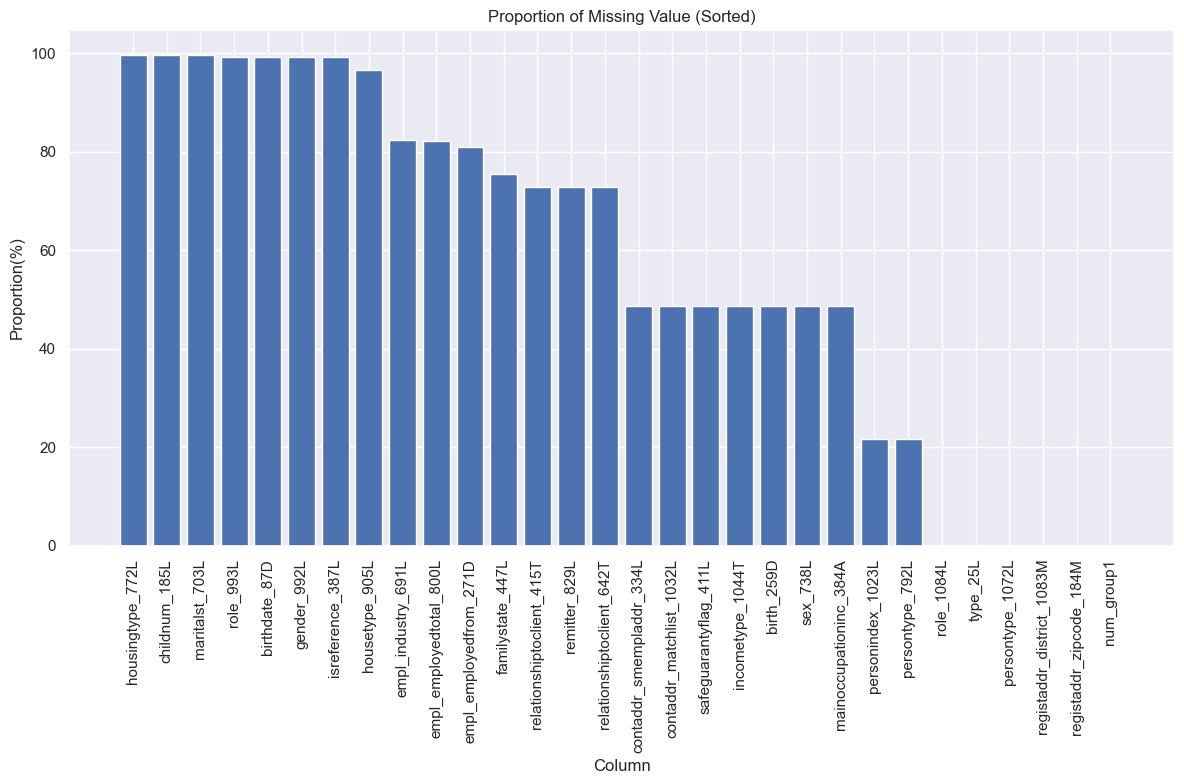

In [103]:
fig, ax = plt.subplots(figsize=(12,8))
null_plot(ax, table_dev)
plt.tight_layout();

In [104]:
# How many unique 'num_group1' per case
contract_count = table_dev[["case_id", "num_group1"]].group_by('case_id').agg(pl.col('num_group1').n_unique()).sort("case_id")["num_group1"]
contract_count.to_pandas().describe()[1:]

mean     1.948039
std      1.120952
min      1.000000
25%      1.000000
50%      1.000000
75%      3.000000
max     10.000000
Name: num_group1, dtype: float64

In [105]:
view_sample_obvs(table_dev, seed)

,case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,250048,10261.0,NaN,NaN,P177_148_53,False,False,P113_46_169,P33_146_175,2729.0,NaN,NaN,a55475b1,a55475b1,SINGLE,NaN,OWNED,NaN,SALARIED_GOVT,None,a55475b1,64000.0,NaN,0,0.0,1.0,1.0,P177_148_53,P113_46_169,NaN,NaN,None,CL,NaN,False,F,HOME_PHONE
1,250048,NaN,NaN,NaN,a55475b1,None,None,a55475b1,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,None,a55475b1,NaN,NaN,1,1.0,1.0,5.0,a55475b1,a55475b1,COLLEAGUE,NaN,False,CL,NaN,None,NaN,PRIMARY_MOBILE
2,250048,NaN,NaN,NaN,a55475b1,None,None,a55475b1,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,None,a55475b1,NaN,NaN,2,NaN,5.0,NaN,a55475b1,a55475b1,NaN,COLLEAGUE,None,PE,NaN,None,NaN,PHONE
3,1255084,22417.0,NaN,NaN,P204_99_158,False,False,P212_16_169,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,PRIVATE_SECTOR_EMPLOYEE,None,P209_127_106,100000.0,NaN,0,0.0,1.0,1.0,P204_99_158,P212_16_169,NaN,NaN,None,CL,NaN,True,M,PRIMARY_MOBILE
4,1819596,17730.0,17730.0,NaN,P48_137_100,False,False,P91_142_108,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,F,NaN,NaN,EMPLOYED,True,P209_127_106,70000.0,NaN,0,0.0,1.0,1.0,P48_137_100,P91_142_108,NaN,NaN,None,CL,FULL,True,F,PRIMARY_MOBILE
5,1819596,NaN,17730.0,NaN,a55475b1,None,None,a55475b1,P33_146_175,NaN,NaN,NaN,a55475b1,a55475b1,NaN,F,NaN,NaN,NaN,False,a55475b1,NaN,MARRIED,1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,None,NaN,FULL,None,NaN,NaN
6,1857144,16078.0,NaN,NaN,P82_153_182,False,False,P59_2_148,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,OWNED,NaN,SALARIED_GOVT,None,P209_127_106,60000.0,NaN,0,0.0,1.0,1.0,P173_115_85,a55475b1,NaN,NaN,None,CL,NaN,False,F,PRIMARY_MOBILE
7,2701828,26295.0,NaN,NaN,P132_42_169,False,False,P170_41_168,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,RETIRED_PENSIONER,None,P209_127_106,26800.0,NaN,0,0.0,1.0,1.0,P132_42_169,P170_41_168,NaN,NaN,None,CL,NaN,True,F,PRIMARY_MOBILE


Extract the first observation of each `case_id` as it corresponds to the applicant his/herself.

In [106]:
table_dev_1st = table_dev.group_by('case_id').first().sort(by='case_id')
table_dev_1st = table_dev_1st.drop("num_group1")

In [107]:
table_sub_1st = table_sub.group_by('case_id').first().sort(by='case_id')
table_sub_1st = table_sub_1st.drop("num_group1")

Count the number of related person found.

In [108]:
count = table_dev[["case_id", "num_group1"]].group_by('case_id').max()
count = count.rename({"num_group1": "related_person_count"})
table_dev_1st = table_dev_1st.join(count, on="case_id", how="left")

In [109]:
count = table_sub[["case_id", "num_group1"]].group_by('case_id').max()
count = count.rename({"num_group1": "related_person_count"})
table_sub_1st = table_sub_1st.join(count, on="case_id", how="left")

In [110]:
summary = summarize(table_dev_1st, feat_def)

In [111]:
summary[summary["Missing_Prop"] == 0]  # same as base_list @Jeffrey

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0,NaN,False,NaN,1526659.0,1.286077e+06,718946.5923,0.0,766197.5,1357358.0,1739022.5,2703454.0
1,34,sex_738L,0.0,Gender of the client.,False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31,role_1084L,0.0,Type of contact role.,False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27,registaddr_zipcode_184M,0.0,Registered address's zip code of a person.,False,3531.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26,registaddr_district_1083M,0.0,District of person's registered address.,False,991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,25,persontype_792L,0.0,Person type.,True,NaN,1526659.0,1.000000e+00,0.0000,1.0,1.0,1.0,1.0,1.0
6,24,persontype_1072L,0.0,Person type.,True,NaN,1526659.0,1.000000e+00,0.0000,1.0,1.0,1.0,1.0,1.0
7,23,personindex_1023L,0.0,Order of the person specified on the application form.,True,NaN,1526659.0,0.000000e+00,0.0000,0.0,0.0,0.0,0.0,0.0
8,21,mainoccupationinc_384A,0.0,Amount of the main income of the client.,False,NaN,1526659.0,5.770747e+04,33315.6445,0.0,36000.0,50000.0,70000.0,200000.0
9,20,language1_981M,0.0,The primary language of the person.,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now those columns can be treated as static attributes.
- Districts and Zip code should contain similar information. Keep districts only as it has less unique class.
- Columns with all values duplicated should be dropped.

In [112]:
drop_list = ["contaddr_zipcode_807M", "empladdr_zipcode_114M", "personindex_1023L", "persontype_1072L", "persontype_792L", "registaddr_zipcode_184M"]
table_dev_1st = table_dev_1st.drop(drop_list)
table_sub_1st = table_sub_1st.drop(drop_list)

In [113]:
summary[summary["Missing_Prop"] != 0]  # same as nonbase_list @Jeffrey

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
20,5,contaddr_matchlist_1032L,0.0003,Indicates whether the contact address is found in a code list.,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,6,contaddr_smempladdr_334L,0.0003,Indicates whether the contact address is the same as the employment address.,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,14,familystate_447L,0.5227,Family state of the person.,False,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,9,empl_employedfrom_271D,0.6288,Start date of employment.,False,NaN,566701.0,2208.6830,2275.9910,-13.0,643.00,1432.0,2985.00,20603.0
24,10,empl_employedtotal_800L,0.6539,Employment length of a person.,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,11,empl_industry_691L,0.6579,Employment Industry of the person.,False,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,16,housetype_905L,0.9340,House type of the person.,False,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,19,isreference_387L,0.9918,Flag indicating whether the person is a reference contact.,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2,birthdate_87D,0.9918,Birth date of the person.,False,NaN,12458.0,14096.0287,4245.7071,7663.0,10923.25,13040.0,16408.75,27568.0
29,32,role_993L,0.9918,Person's role.,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop columns with p > 0.9.

In [114]:
drop_list = summary.loc[summary["Missing_Prop"] > 0.9, "Column"].to_numpy()
table_dev_1st = table_dev_1st.drop(drop_list)
table_sub_1st = table_sub_1st.drop(drop_list)

In [115]:
table_dev_1st = fill_missing_value(table_dev_1st)
table_sub_1st = fill_missing_value(table_sub_1st)

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [116]:
table_dev_1st.shape

(1526659, 20)

In [117]:
table_sub_1st.shape

(3, 20)

In [118]:
development_clean[table] = table_dev_1st.clone()
submission_clean[table] = table_sub_1st.clone()

## `person_2`

In [119]:
table = "person_2"

In [120]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [121]:
table_dev.shape

(1643410, 11)

In [122]:
summarize(table_dev, feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,1643410.0,1.264005e+06,699545.4755,5.0,761958.25,1323515.5,1695936.75,2703454.0
1,1,addres_district_368M,0.0000,District of the person's address.,False,508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,addres_zip_823M,0.0000,Zip code of the address.,False,2027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,conts_role_79M,0.0000,Type of contact role of a person.,False,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,empls_economicalst_849M,0.0000,"The economical status of the person (num_group1 - person, num_group2 - employment).",False,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,empls_employer_name_740M,0.0000,"Employer's name (num_group1 - person, num_group2 - employment).",False,7153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,num_group1,0.0000,NaN,False,NaN,1643410.0,1.115000e-01,0.3224,0.0,0.00,0.0,0.00,4.0
7,9,num_group2,0.0000,NaN,False,NaN,1643410.0,1.237000e-01,0.7612,0.0,0.00,0.0,0.00,31.0
8,2,addres_role_871L,0.9588,Role of person's address.,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,relatedpersons_role_762T,0.9825,"Relationship type of a client's related person (num_group1 - person, num_group2 - related person).",False,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


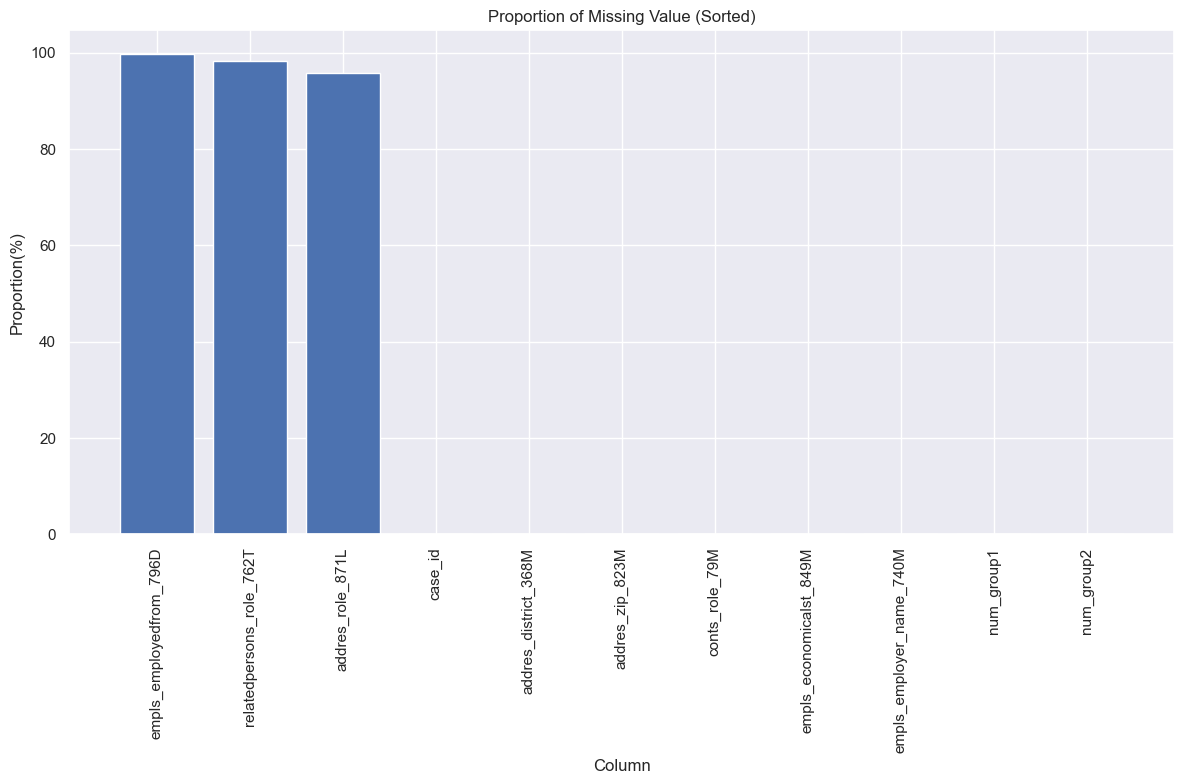

In [123]:
fig, ax = plt.subplots(figsize=(12,8))
null_plot(ax, table_dev)
plt.tight_layout();

In [124]:
view_sample_obvs(table_dev, seed)

,case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
0,622637,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
1,730079,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
2,1305600,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
3,1878451,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN
4,2529877,a55475b1,NaN,a55475b1,a55475b1,a55475b1,NaN,a55475b1,0,0,NaN


In [125]:
# How many unique 'num_group1' per case
num1_count = table_dev[["case_id", "num_group1"]].group_by('case_id').agg(pl.col('num_group1').n_unique()).sort("case_id")
num1_count["num_group1"].to_pandas().describe()[1:]

mean    1.087920
std     0.285307
min     1.000000
25%     1.000000
50%     1.000000
75%     1.000000
max     4.000000
Name: num_group1, dtype: float64

In [126]:
# Proportion of case_id having no employment record of related person
(num1_count["num_group1"] == 1).sum() / len(num1_count)

0.9126837409109438

In [127]:
# How many unique 'num_group2' per case and 'num_group1"
num2_count = table_dev[["case_id", "num_group1", "num_group2"]].group_by('case_id', 'num_group1').agg(pl.col('num_group2').n_unique()).sort("case_id")
num2_count["num_group2"].to_pandas().describe()[1:]

mean     1.052604
std      0.452820
min      1.000000
25%      1.000000
50%      1.000000
75%      1.000000
max     32.000000
Name: num_group2, dtype: float64

In [128]:
obvs_count = table_dev["case_id"].value_counts()

In [129]:
# Proportion of case_id having only one observation in this dataset
(obvs_count.filter(pl.col("count") == 1)["count"]).sum() / len(table_dev)

0.785828855854595

In [130]:
# Check the first observation of case_id with only 1 observation
case_wt_1obvs = obvs_count.filter(pl.col("count") == 1)["case_id"].to_numpy()
summarize(table_dev.filter(pl.col("case_id").is_in(case_wt_1obvs)), feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0,NaN,False,NaN,1291439.0,1.333967e+06,719840.6284,5.0,802182.5,1402961.0,1746456.5,2703454.0
1,1,addres_district_368M,0.0,District of the person's address.,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,addres_zip_823M,0.0,Zip code of the address.,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,conts_role_79M,0.0,Type of contact role of a person.,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,empls_economicalst_849M,0.0,"The economical status of the person (num_group1 - person, num_group2 - employment).",True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,empls_employer_name_740M,0.0,"Employer's name (num_group1 - person, num_group2 - employment).",True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,num_group1,0.0,NaN,False,NaN,1291439.0,1.000000e-04,0.0075,0.0,0.0,0.0,0.0,2.0
7,9,num_group2,0.0,NaN,True,NaN,1291439.0,0.000000e+00,0.0000,0.0,0.0,0.0,0.0,0.0
8,2,addres_role_871L,1.0,Role of person's address.,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6,empls_employedfrom_796D,1.0,"Start of employment (num_group1 - person, num_group2 - employment).",False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
# Check the first observation of each case_id
summarize(table_dev.filter((pl.col("num_group1") == 0) & (pl.col("num_group2") == 0)), feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,1435041.0,1.297356e+06,712007.3914,5.0,777229.0,1362143.0,1721744.0,2703454.0
1,1,addres_district_368M,0.0000,District of the person's address.,False,406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,addres_zip_823M,0.0000,Zip code of the address.,False,1459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,conts_role_79M,0.0000,Type of contact role of a person.,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,empls_economicalst_849M,0.0000,"The economical status of the person (num_group1 - person, num_group2 - employment).",False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,empls_employer_name_740M,0.0000,"Employer's name (num_group1 - person, num_group2 - employment).",False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,num_group1,0.0000,NaN,True,NaN,1435041.0,0.000000e+00,0.0000,0.0,0.0,0.0,0.0,0.0
7,9,num_group2,0.0000,NaN,True,NaN,1435041.0,0.000000e+00,0.0000,0.0,0.0,0.0,0.0,0.0
8,2,addres_role_871L,0.9915,Role of person's address.,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6,empls_employedfrom_796D,1.0000,"Start of employment (num_group1 - person, num_group2 - employment).",True,NaN,1.0,2.997000e+03,NaN,2997.0,2997.0,2997.0,2997.0,2997.0


In [132]:
# Employment record of applicant with > 1 observation
summarize(table_dev.filter((pl.col("num_group1") == 0) & (pl.col("num_group2") != 0)), feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,28887.0,1.202293e+06,568064.0161,6.0,767089.5,1280722.0,1598635.0,2702751.0
1,1,addres_district_368M,0.0000,District of the person's address.,False,216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,addres_zip_823M,0.0000,Zip code of the address.,False,759.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,conts_role_79M,0.0000,Type of contact role of a person.,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,empls_economicalst_849M,0.0000,"The economical status of the person (num_group1 - person, num_group2 - employment).",True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,empls_employer_name_740M,0.0000,"Employer's name (num_group1 - person, num_group2 - employment).",True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,num_group1,0.0000,NaN,True,NaN,28887.0,0.000000e+00,0.0000,0.0,0.0,0.0,0.0,0.0
7,9,num_group2,0.0000,NaN,False,NaN,28887.0,1.046400e+00,0.2307,1.0,1.0,1.0,1.0,8.0
8,2,addres_role_871L,0.8467,Role of person's address.,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6,empls_employedfrom_796D,1.0000,"Start of employment (num_group1 - person, num_group2 - employment).",False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
summarize(table_dev.filter((pl.col("num_group1") != 0) & (pl.col("num_group2") == 0)), feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,126239.0,916822.7547,511258.1938,6.0,682077.00,826979.0,959823.5,2703094.0
1,1,addres_district_368M,0.0000,District of the person's address.,False,291.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,addres_zip_823M,0.0000,Zip code of the address.,False,1546.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,conts_role_79M,0.0000,Type of contact role of a person.,False,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,empls_economicalst_849M,0.0000,"The economical status of the person (num_group1 - person, num_group2 - employment).",False,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,empls_employer_name_740M,0.0000,"Employer's name (num_group1 - person, num_group2 - employment).",False,7153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,num_group1,0.0000,NaN,False,NaN,126239.0,1.0292,0.1753,1.0,1.00,1.0,1.0,4.0
7,9,num_group2,0.0000,NaN,True,NaN,126239.0,0.0000,0.0000,0.0,0.00,0.0,0.0,0.0
8,2,addres_role_871L,0.9015,Role of person's address.,False,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,relatedpersons_role_762T,0.9208,"Relationship type of a client's related person (num_group1 - person, num_group2 - related person).",False,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
# Employment record of non-applicant with > 1 observation
summarize(table_dev.filter((pl.col("num_group1") != 0) & (pl.col("num_group2") != 0)), feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,53243.0,1.221746e+06,571495.9460,6.0,800611.0,1336868.0,1637265.0,2703094.0
1,1,addres_district_368M,0.0000,District of the person's address.,False,411.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,addres_zip_823M,0.0000,Zip code of the address.,False,1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,conts_role_79M,0.0000,Type of contact role of a person.,False,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,empls_economicalst_849M,0.0000,"The economical status of the person (num_group1 - person, num_group2 - employment).",True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,empls_employer_name_740M,0.0000,"Employer's name (num_group1 - person, num_group2 - employment).",True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,num_group1,0.0000,NaN,False,NaN,53243.0,1.002600e+00,0.0527,1.0,1.0,1.0,1.0,3.0
7,9,num_group2,0.0000,NaN,False,NaN,53243.0,3.250500e+00,2.6778,1.0,1.0,2.0,4.0,31.0
8,2,addres_role_871L,0.2761,Role of person's address.,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,relatedpersons_role_762T,0.6484,"Relationship type of a client's related person (num_group1 - person, num_group2 - related person).",False,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
- Most of the `case_id` in `person_2` has one observation.
- This is nonsense as we cannot believe all people live in the same district.
- For case_id with only 1 observation, all observations are equal.
- Few observations have information of related person.

Aggregation Scheme:
- Focus on the applicant's own record (filter: num_group1==0)
- Find the first and last record
- Add a feature of how many employment record we found (i.e. number of unique num_group2)
- Add a feature of how many related person we found (i.e. number of unique num_group1)

In [135]:
table_dev_1st = table_dev.filter(pl.col("num_group1") == 0)
table_sub_1st = table_sub.filter(pl.col("num_group1") == 0)

In [136]:
summarize(table_dev_1st, feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,1463928.0,1.295481e+06,709572.5724,5.0,776994.75,1359956.5,1719454.25,2703454.0
1,1,addres_district_368M,0.0000,District of the person's address.,False,406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,addres_zip_823M,0.0000,Zip code of the address.,False,1459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,conts_role_79M,0.0000,Type of contact role of a person.,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,empls_economicalst_849M,0.0000,"The economical status of the person (num_group1 - person, num_group2 - employment).",False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,empls_employer_name_740M,0.0000,"Employer's name (num_group1 - person, num_group2 - employment).",False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,8,num_group1,0.0000,NaN,True,NaN,1463928.0,0.000000e+00,0.0000,0.0,0.00,0.0,0.00,0.0
7,9,num_group2,0.0000,NaN,False,NaN,1463928.0,2.060000e-02,0.1491,0.0,0.00,0.0,0.00,8.0
8,2,addres_role_871L,0.9886,Role of person's address.,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,6,empls_employedfrom_796D,1.0000,"Start of employment (num_group1 - person, num_group2 - employment).",True,NaN,1.0,2.997000e+03,NaN,2997.0,2997.00,2997.0,2997.00,2997.0


In [137]:
drop_list = ["addres_role_871L", "empls_employedfrom_796D", "relatedpersons_role_762T"]
table_dev_1st = table_dev_1st.drop(drop_list)
table_sub_1st = table_sub_1st.drop(drop_list)

In [138]:
table_dev_1st = aggregate(table_dev_1st, True)
table_sub_1st = aggregate(table_sub_1st, True)

In [139]:
count = table_dev[["case_id", "num_group1"]].group_by('case_id').max()
count = count.rename({"num_group1": "related_person_count"})
table_dev_1st = table_dev_1st.join(count, on="case_id", how="left")

In [140]:
count = table_sub[["case_id", "num_group1"]].group_by('case_id').max()
count = count.rename({"num_group1": "related_person_count"})
table_sub_1st = table_sub_1st.join(count, on="case_id", how="left")

In [141]:
summarize(table_dev_1st, feat_def)

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0,NaN,False,NaN,1435041.0,1.297356e+06,712007.3914,5.0,777229.0,1362143.0,1721744.0,2703454.0
1,1,addres_district_368M_first,0.0,NaN,False,406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,addres_zip_823M_first,0.0,NaN,False,1459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,conts_role_79M_first,0.0,NaN,False,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,empls_economicalst_849M_first,0.0,NaN,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,empls_employer_name_740M_first,0.0,NaN,False,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,addres_district_368M_last,0.0,NaN,False,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,addres_zip_823M_last,0.0,NaN,False,1418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,conts_role_79M_last,0.0,NaN,False,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,empls_economicalst_849M_last,0.0,NaN,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Zipcode is unnecessary as we have information about district and zipcode have more classes
- Drop columns with all duplicated values

In [142]:
drop_list = np.array(table_dev_1st.columns)[['zip' in col for col in table_dev_1st.columns]]
drop_list = np.concatenate([drop_list, ["empls_employer_name_740M_last"]])
table_dev_1st = table_dev_1st.drop(drop_list)
table_sub_1st = table_sub_1st.drop(drop_list)

In [143]:
table_dev_1st.shape

(1435041, 10)

In [144]:
table_sub_1st.shape

(10, 10)

In [145]:
# Handle missing columns in df_test
df = pl.concat([table_dev_1st, table_sub_1st], how="diagonal_relaxed")
df = fill_missing_value(df)
table_sub_1st = df.tail(table_sub_1st.shape[0])

/var/folders/r2/33czvw094ssg0r61q08cprnw0000gn/T/ipykernel_33770/2965471965.py:2: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = pl.concat([table_dev_1st, table_sub_1st], how="diagonal_relaxed")


In [146]:
table_sub_1st.shape

(10, 10)

In [147]:
development_clean[table] = table_dev_1st.clone()
submission_clean[table] = table_sub_1st.clone()

## `credit_bureau_a_1`

In [148]:
table = "credit_bureau_a_1"

In [149]:
table_dev = development[table].clone()
table_sub = submission[table].clone()

In [150]:
table_dev.shape

(15940537, 79)

In [151]:
summary = summarize(table_dev, feat_def)
summary

,index,Column,Missing_Prop,Description,All_Obvs_Equal,N_Unique,count,mean,std,min,25%,50%,75%,max
0,0,case_id,0.0000,NaN,False,NaN,15940537.0,1.327830e+06,7.282960e+05,388.0,791502.0000,1.423322e+06,1.773789e+06,2.703454e+06
1,25,financialinstitution_591M,0.0000,Financial institution name of the active contract.,False,238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24,financialinstitution_382M,0.0000,Name of financial institution that is linked to a closed contract.,False,390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17,description_351M,0.0000,Categorization of clients by credit bureau.,False,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35,num_group1,0.0000,NaN,False,NaN,15940537.0,6.324600e+00,6.998500e+00,0.0,2.0000,5.000000e+00,8.000000e+00,5.280000e+02
5,67,purposeofcred_874M,0.0000,Purpose of credit on a closed contract.,False,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,71,subjectrole_182M,0.0000,Subject role in active credit contract.,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,66,purposeofcred_426M,0.0000,Purpose of credit for active contract.,False,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,6,contractst_964M,0.0000,Contract status of terminated credit contract.,False,295.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,72,subjectrole_93M,0.0000,Subject role in closed credit contract.,False,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


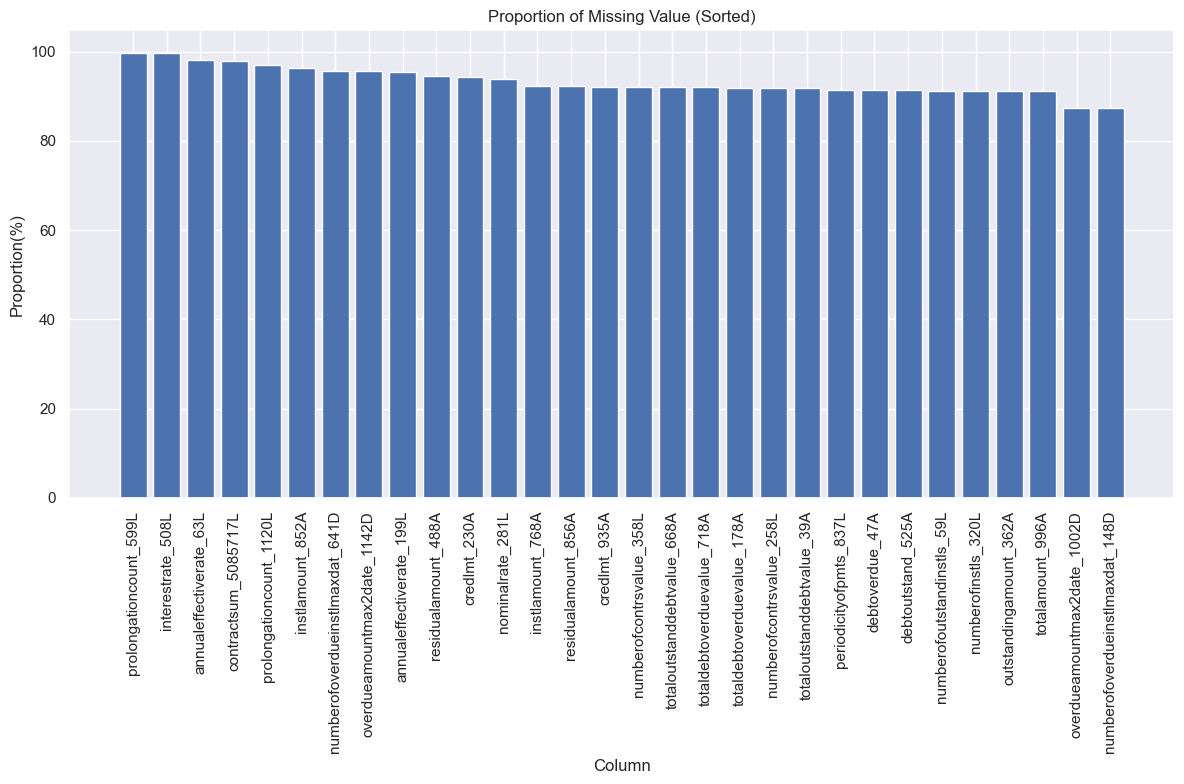

In [152]:
fig, ax = plt.subplots(figsize=(12,8))
null_plot(ax, table_dev)
plt.tight_layout();

In [153]:
# How many unique 'num_group1' per case
contract_count = table_dev[["case_id", "num_group1"]].group_by('case_id').agg(pl.col('num_group1').n_unique()).sort("case_id")["num_group1"]
contract_count.to_pandas().describe()[1:]

mean     11.498844
std       4.969215
min       1.000000
25%       9.000000
50%      10.000000
75%      11.000000
max     529.000000
Name: num_group1, dtype: float64

In [154]:
view_sample_obvs(table_dev, seed)

,case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
0,1946582,NaN,NaN,ea6782cc,4538d522,7241344e,7241344e,0.000000,40400.0,0.0,-693.0,3402.0,4497.0,2229.0,3402.0,917898.687500,0.0,a55475b1,0.0,1.0,6.0,11.0,2018.0,2010.0,P150_136_157,b619fa46,0.000000,0.0,NaN,5.0,3386.0,0.000000,0.000000,NaN,NaN,0,3.0,8.0,NaN,NaN,NaN,NaN,3.0,1.0,3741.0,1283.0,0.0,0.0,NaN,NaN,0.0,0.0,992.175964,1588.004028,3741.0,1283.0,0.0,1588.004028,7.0,11.0,2018.0,2010.0,30.0,NaN,NaN,NaN,60c73645,5065c2b8,-12.0,0.0,0.000000,ab3c25cf,ab3c25cf,NaN,NaN,0.0,0.0,917898.687500,0.0
1,1946582,NaN,9.170000,4408ff0f,ea6782cc,7241344e,7241344e,189493.703125,NaN,NaN,-1882.0,2702.0,3099.0,675.0,2702.0,NaN,NaN,a55475b1,0.0,14.0,5.0,12.0,2018.0,2013.0,P150_136_157,66b2baaa,NaN,NaN,NaN,0.0,2560.0,6233.333984,0.000000,8.5,NaN,1,NaN,NaN,0.0,84.0,0.0,62.0,0.0,15.0,2727.0,NaN,0.0,0.0,0.0,880000.000000,0.0,0.0,0.000000,6.482000,2772.0,NaN,0.0,6.482000,3.0,12.0,2018.0,2013.0,30.0,30.0,NaN,NaN,60c73645,5065c2b8,-14.0,NaN,NaN,a55475b1,a55475b1,74000.000000,880000.000000,NaN,NaN,NaN,NaN
2,1946582,NaN,NaN,ea6782cc,ea6782cc,7241344e,7241344e,NaN,NaN,NaN,-138.0,1446.0,1538.0,46.0,1445.0,NaN,NaN,a55475b1,0.0,24.0,9.0,9.0,2020.0,2016.0,Home Credit,Home Credit,NaN,NaN,NaN,-3.0,1445.0,8269.600586,3191.800049,45.0,45.000000,2,NaN,NaN,3.0,6.0,0.0,5.0,0.0,26.0,1482.0,NaN,0.0,0.0,0.0,37898.742188,0.0,0.0,0.000000,32.200001,1482.0,NaN,0.0,32.200001,9.0,9.0,2020.0,2016.0,30.0,30.0,NaN,NaN,60c73645,60c73645,-14.0,NaN,NaN,a55475b1,a55475b1,8893.400391,43682.800781,NaN,NaN,NaN,NaN
3,1946582,NaN,NaN,a55475b1,ea6782cc,a55475b1,7241344e,NaN,NaN,NaN,NaN,1292.0,1382.0,NaN,1290.0,NaN,NaN,a55475b1,NaN,0.0,1.0,NaN,NaN,2017.0,Home Credit,a55475b1,NaN,NaN,NaN,NaN,1290.0,NaN,3009.000000,NaN,45.000000,3,NaN,NaN,3.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,1.0,NaN,NaN,2017.0,30.0,NaN,NaN,NaN,a55475b1,60c73645,NaN,NaN,NaN,a55475b1,a55475b1,8388.000000,NaN,NaN,NaN,NaN,NaN
4,1946582,NaN,NaN,a55475b1,ea6782cc,a55475b1,7241344e,NaN,NaN,NaN,NaN,782.0,905.0,NaN,781.0,NaN,NaN,a55475b1,NaN,0.0,5.0,NaN,NaN,2018.0,Home Credit,a55475b1,NaN,NaN,NaN,NaN,781.0,NaN,8363.200195,NaN,45.000000,4,NaN,NaN,4.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,5.0,NaN,NaN,2018.0,30.0,NaN,NaN,NaN,a55475b1,60c73645,641.0,NaN,N

Conclusion:
Data from credit bureau should not be used in our project, because:
- (Major) The aim of this project is to assess the credit risk of people with little or no credit history. If we highly rely on credit history to make prediction and treat those people as missing value, our model will probably fail in those cases.
- (Minor) There are many types of contracts from different financial insitiutions being concatenated together, creating many missing values due to contract nature and booking ways. Given the huge size and complexity of the dataset, it is extremely difficult, if not impossible, to identify a missing value is MAR or MNAR or not.

## Table Merging

In [155]:
df_dev = join_data(development_clean)
df_sub = join_data(submission_clean)

In [156]:
df_dev = fill_missing_value(df_dev, is_merge=True)
df_sub = fill_missing_value(df_sub, is_merge=True)

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


## Encoding Categorical Features
The vast number of unique categorys can cause the curse of dimensionality and thus a high risk of overfitting if one-hot encoding is applied. Therefore, label encoding is used in this project. Although most of our categorical features are not ordinal, we hope the non-linearity of XGBoost and MLP can alleivate the problem. 

In [157]:
cat_feat = [col for col in df_dev.columns if df_dev[col].dtype == pl.Categorical]

In [158]:
len(cat_feat)  # How many categorical features?

69

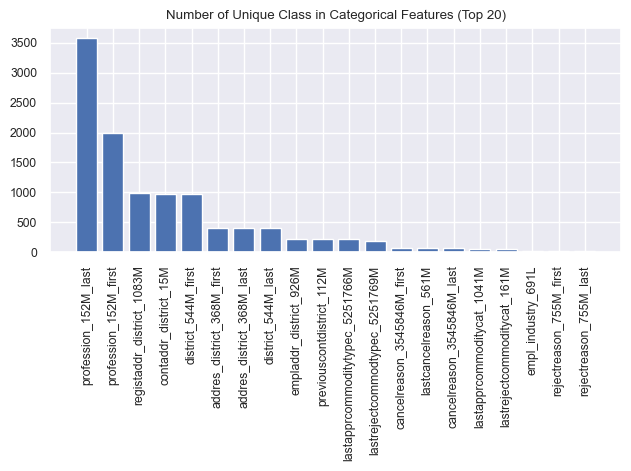

In [159]:
sns.set_theme(font_scale=0.8)
Xcat_nunique = df_dev[cat_feat].select(pl.all().n_unique())
Xcat_nunique = Xcat_nunique.to_pandas().T.sort_values(by=0, ascending=False)
Xcat_nunique = Xcat_nunique.iloc[:20]
plt.bar(Xcat_nunique.index, Xcat_nunique[0])
plt.xticks(rotation=90)
plt.title("Number of Unique Class in Categorical Features (Top 20)")
plt.tight_layout();

In [160]:
encoder = OrdinalEncoder()

In [161]:
df_cat = pl.concat([df_dev[cat_feat], df_sub[cat_feat]], how="vertical")
encoder.fit(df_cat[cat_feat])

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


OrdinalEncoder()

In [162]:
df_cat = encoder.transform(df_dev[cat_feat])
df_cat = pl.from_numpy(df_cat)
df_cat = df_cat.select(pl.all().cast(pl.Int16))
df_cat.columns = cat_feat
df_dev = pl.concat([df_dev.drop(cat_feat), df_cat], how="horizontal")

In [163]:
df_cat = encoder.transform(df_sub[cat_feat])  # NOT fit_transform!!!
df_cat = pl.from_numpy(df_cat)
df_cat = df_cat.select(pl.all().cast(pl.Int16))
df_cat.columns = cat_feat
df_sub = pl.concat([df_sub.drop(cat_feat), df_cat], how="horizontal")

## Output 

In [164]:
gc.collect()

54243

In [165]:
df_dev[["case_id", "case_gp", "MONTH", "WEEK_NUM", "target", "date_decision"]].write_csv(data_path+"/cleaned/dev_base.csv")
df_dev.drop(["MONTH", "WEEK_NUM", "target", "date_decision"]).write_csv(data_path+"/cleaned/dev_feat.csv")
df_sub[["case_id", "case_gp", "MONTH", "WEEK_NUM", "date_decision"]].write_csv(data_path+"/cleaned/sub_base.csv")
df_sub.drop(["MONTH", "WEEK_NUM", "date_decision"]).write_csv(data_path+"/cleaned/sub_feat.csv")